In [79]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from PIL import Image
from pathlib import Path
import warnings

plt.rcParams['axes.axisbelow'] = True

In [88]:
rho = 0.25
c = 2.0
u_l = 1.0
u_r = 0.0
p_l = 5.0
p_r = 2.0

omega = np.array([[1 , 1],
                  [rho * c, - rho * c]])

omega_inv = 0.5 * np.array([[1, 1 / (rho * c)],
                            [1, - 1 / (rho * c)]])

def vanLeerCriterion(u1, u2, u):
    return np.min((u1, u2)) <= u and np.max((u1, u2)) >= u

def solveTransfer(c, u_init, coeffs, r_min = -1.0, r_max = 1.0, I = 200, CFL = 0.25, alt_coeffs_1 = np.zeros(4), alt_coeffs_2 = np.zeros(4)):
    h = (r_max - r_min) / I
    r_i = np.array([r_min + iter * h for iter in range(I)])
    tau = CFL * h / np.abs(c)
    num_time_steps = 100
    T = tau * num_time_steps
    t_i = np.linspace(0., T, num_time_steps)
    u = np.zeros((t_i.size, r_i.size))
    u[0, :] = u_init(r_i)

    for m in range(1, I - 1):
        # Аппроксимируем второй слой со вторым порядком (кроме границ)
        u[1, m] =  u[0, m] - 0.5 * CFL * (u[0, m + 1] - u[0, m - 1]) + 0.5 * CFL ** 2 * (u[0, m + 1] - 2 * u[0, m] + u[0, m - 1])
        u[1, 0] = u[0, 1]
        u[1, -1] = u[0, -2]

    for n in range(1, t_i.size - 1):
        if alt_coeffs_1.any():
            for m in range(1, I - 1):
                if c < 0:
                    u[n + 1, m] =  coeffs[0] * u[n, m] + coeffs[1] * u[n, m + 1] + coeffs[2] * u[n - 1, m + 1] + coeffs[3] * u[n - 1, m - 1]
                    if not vanLeerCriterion(u[n, m], u[n - 1, m + 1], u[n + 1, m]):
                        u[n + 1, m] =  alt_coeffs_1[0] * u[n, m] + alt_coeffs_1[1] * u[n, m + 1] + alt_coeffs_1[2] * u[n - 1, m + 1] + alt_coeffs_1[3] * u[n - 1, m - 1]
                    if (not vanLeerCriterion(u[n, m], u[n - 1, m + 1], u[n + 1, m])) and alt_coeffs_2.any():
                        u[n + 1, m] =  alt_coeffs_2[0] * u[n, m] + alt_coeffs_2[1] * u[n, m + 1] + alt_coeffs_2[2] * u[n - 1, m + 1] + alt_coeffs_2[3] * u[n - 1, m - 1]
                else:
                    u[n + 1, m] =  coeffs[0] * u[n, m] + coeffs[1] * u[n, m - 1] + coeffs[2] * u[n - 1, m - 1] + coeffs[3] * u[n - 1, m + 1]
                    if not vanLeerCriterion(u[n, m], u[n - 1, m - 1], u[n + 1, m]):
                        u[n + 1, m] =  alt_coeffs_1[0] * u[n, m] + alt_coeffs_1[1] * u[n, m - 1] + alt_coeffs_1[2] * u[n - 1, m - 1] + alt_coeffs_1[3] * u[n - 1, m + 1]
                    if (not vanLeerCriterion(u[n, m], u[n - 1, m - 1], u[n + 1, m])) and alt_coeffs_2.any():
                        u[n + 1, m] =  alt_coeffs_2[0] * u[n, m] + alt_coeffs_2[1] * u[n, m - 1] + alt_coeffs_2[2] * u[n - 1, m - 1] + alt_coeffs_2[3] * u[n - 1, m + 1]
            u[n + 1, 0] = u[n + 1, 1]
            u[n + 1, -1] = u[n + 1, -2]
        else:
            for m in range(1, I - 1):
                if c < 0:
                    u[n + 1, m] =  coeffs[0] * u[n, m] + coeffs[1] * u[n, m + 1] + coeffs[2] * u[n - 1, m + 1] + coeffs[3] * u[n - 1, m - 1]
                else:
                    u[n + 1, m] =  coeffs[0] * u[n, m] + coeffs[1] * u[n, m - 1] + coeffs[2] * u[n - 1, m - 1] + coeffs[3] * u[n - 1, m + 1]
            u[n + 1, 0] = u[n + 1, 1]
            u[n + 1, -1] = u[n + 1, -2]

    return u, r_i, t_i

In [89]:
Y_init = lambda x: np.piecewise(x, [x < 0, x >= 0], [0.5 * (u_l + p_l / (rho * c)), 0.5 * (u_r + p_r / (rho * c))])
Z_init = lambda x: np.piecewise(x, [x < 0, x >= 0], [0.5 * (u_l - p_l / (rho * c)), 0.5 * (u_r - p_r / (rho * c))])

In [109]:
def analytic_solution(x, t):
    # среднее состояние
    u_star = 0.5 * (u_l + u_r) + 0.5 * (p_l - p_r) / (rho * c)
    p_star = 0.5 * (p_l + p_r) + 0.5 * rho * c * (u_l - u_r)

    xL = - c * t
    xR = c * t

    p = np.zeros_like(x)
    u = np.zeros_like(x)

    # область слева
    mask_left = x < xL
    p[mask_left] = p_l
    u[mask_left] = u_l

    # область посредине
    mask_middle = (x >= xL) & (x <= xR)
    p[mask_middle] = p_star
    u[mask_middle] = u_star

    # область справа
    mask_right = x > xR
    p[mask_right] = p_r
    u[mask_right] = u_r

    return p, u

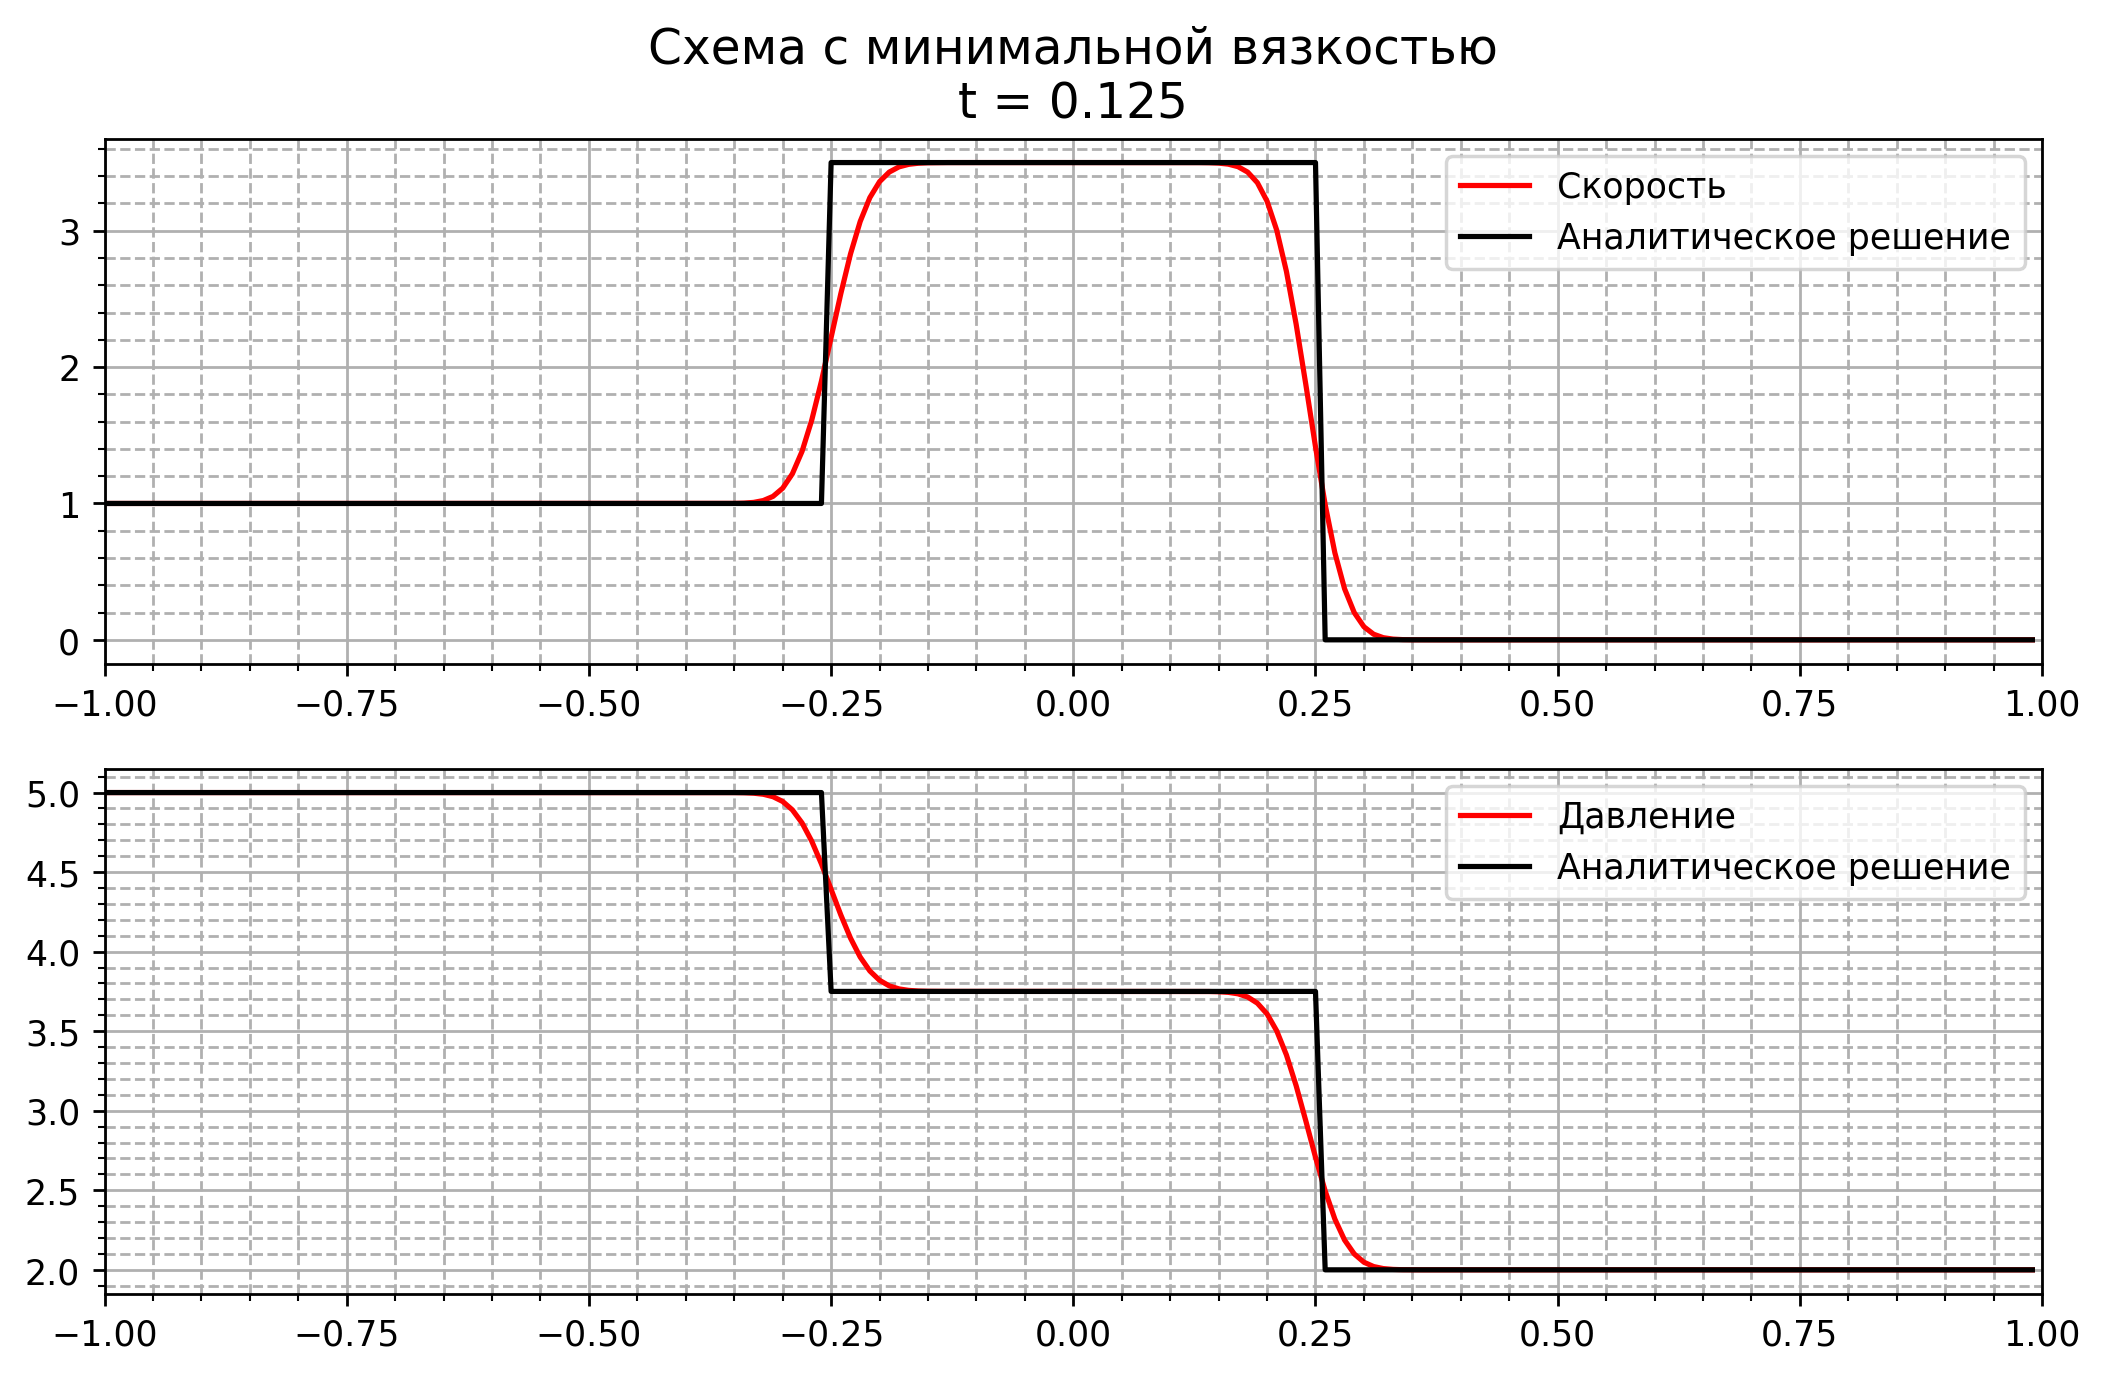

In [111]:
# Схема с мин. вязкостью
plot_title = 'min_vyazk'
Y, r, t = solveTransfer(c, Y_init, [2. / 3, 0, 1. / 3, 0])
Z, r, t = solveTransfer(-c, Z_init, [2. / 3, 0, 1. / 3, 0])

YZ = np.vstack([Y[-1, :], Z[-1, :]])

UP = omega @ YZ

p_true, u_true = analytic_solution(r, t[-1])

fig, ax = plt.subplots(2, 1, figsize=(10, 6), dpi= 250)
ax[0].plot(r, UP[0, :], label= 'Скорость', c = 'red')
ax[0].plot(r, u_true, label= 'Аналитическое решение', c = 'black')
ax[0].legend(loc = 'best')
ax[0].set_title(f'Схема с минимальной вязкостью\nt = {t[-1]}', fontsize=14)
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle='--')
ax[0].minorticks_on()
ax[0].set_xlim((-1., 1.))

ax[1].plot(r, UP[1, :], label= 'Давление', c = 'red')
ax[1].plot(r, p_true, label= 'Аналитическое решение', c = 'black')
ax[1].legend(loc = 'best')
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle='--')
ax[1].minorticks_on()
ax[1].set_xlim((-1., 1.))

fig.savefig(plot_title + '.png', 
    transparent = False,  
    facecolor = 'white'
)

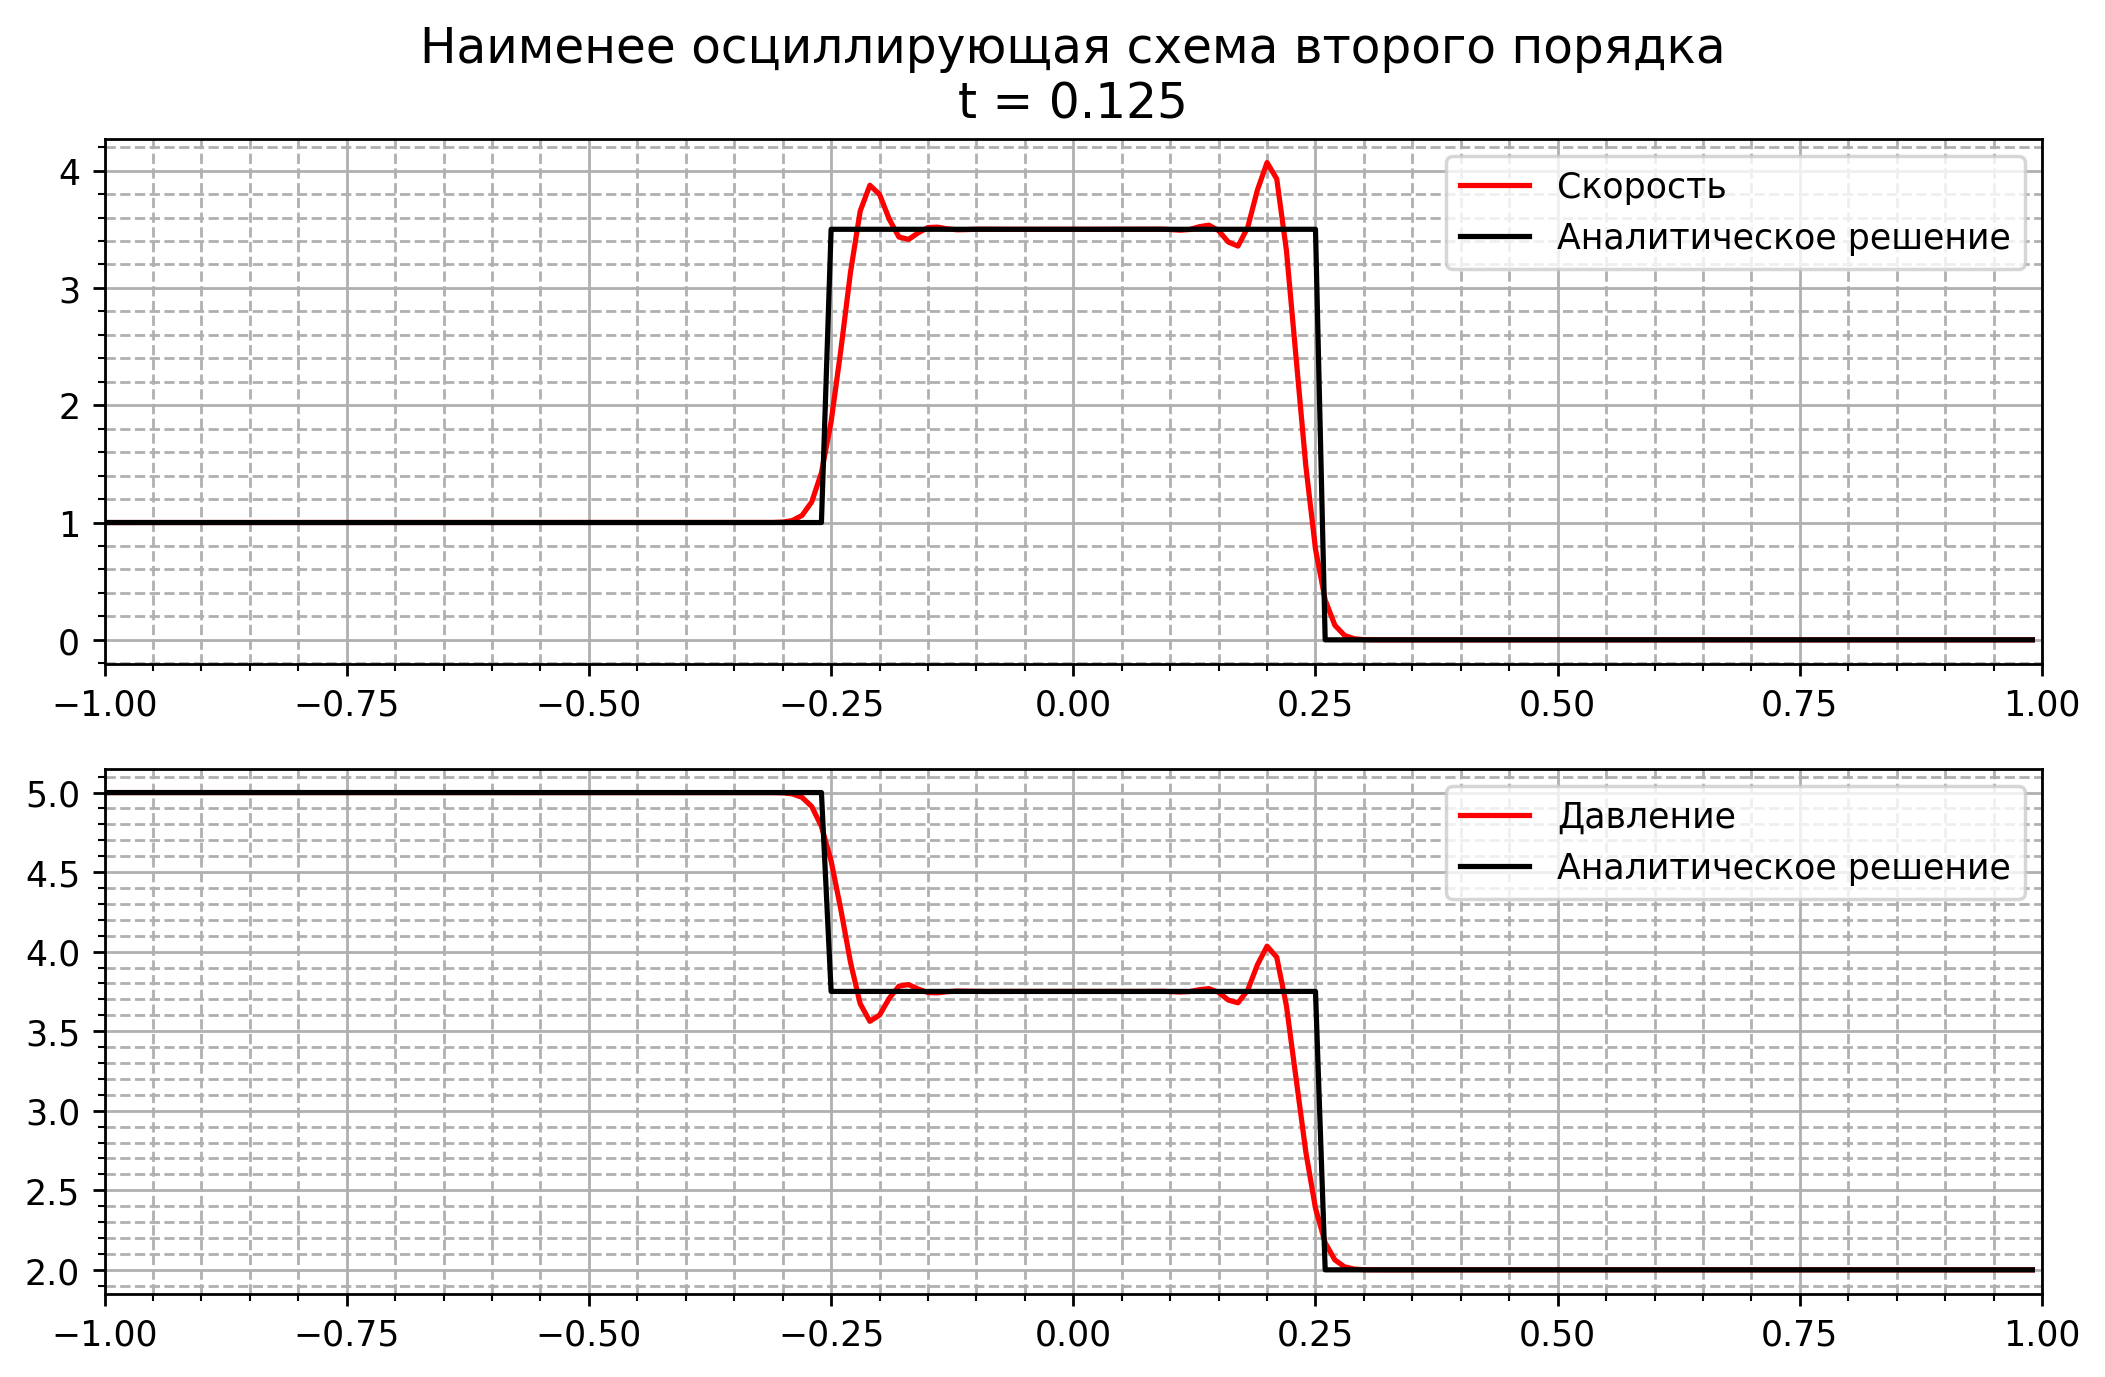

In [112]:
# Схема с наим. осцилляциями
plot_title = 'min_oscill'

a1 = -38./(113*4) + 45./(4*113) + 0.75
a2 = -(3*38./(4*113)) - 25./(4*113) + 0.25
a3 = 38./113
a4 = -5./113

Y, r, t = solveTransfer(c, Y_init, [a1, a2, a3, a4])
Z, r, t = solveTransfer(-c, Z_init, [a1, a2, a3, a4])

YZ = np.vstack([Y[-1, :], Z[-1, :]])

UP = omega @ YZ

p_true, u_true = analytic_solution(r, t[-1])

fig, ax = plt.subplots(2, 1, figsize=(10, 6), dpi= 250)
ax[0].plot(r, UP[0, :], label= 'Скорость', c = 'red')
ax[0].plot(r, u_true, label= 'Аналитическое решение', c = 'black')
ax[0].legend(loc = 'best')
ax[0].set_title(f'Наименее осциллирующая схема второго порядка\nt = {t[-1]}', fontsize=14)
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle='--')
ax[0].minorticks_on()
ax[0].set_xlim((-1., 1.))

ax[1].plot(r, UP[1, :], label= 'Давление', c = 'red')
ax[1].plot(r, p_true, label= 'Аналитическое решение', c = 'black')
ax[1].legend(loc = 'best')
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle='--')
ax[1].minorticks_on()
ax[1].set_xlim((-1., 1.))

fig.savefig(plot_title + '.png', 
    transparent = False,  
    facecolor = 'white'
)

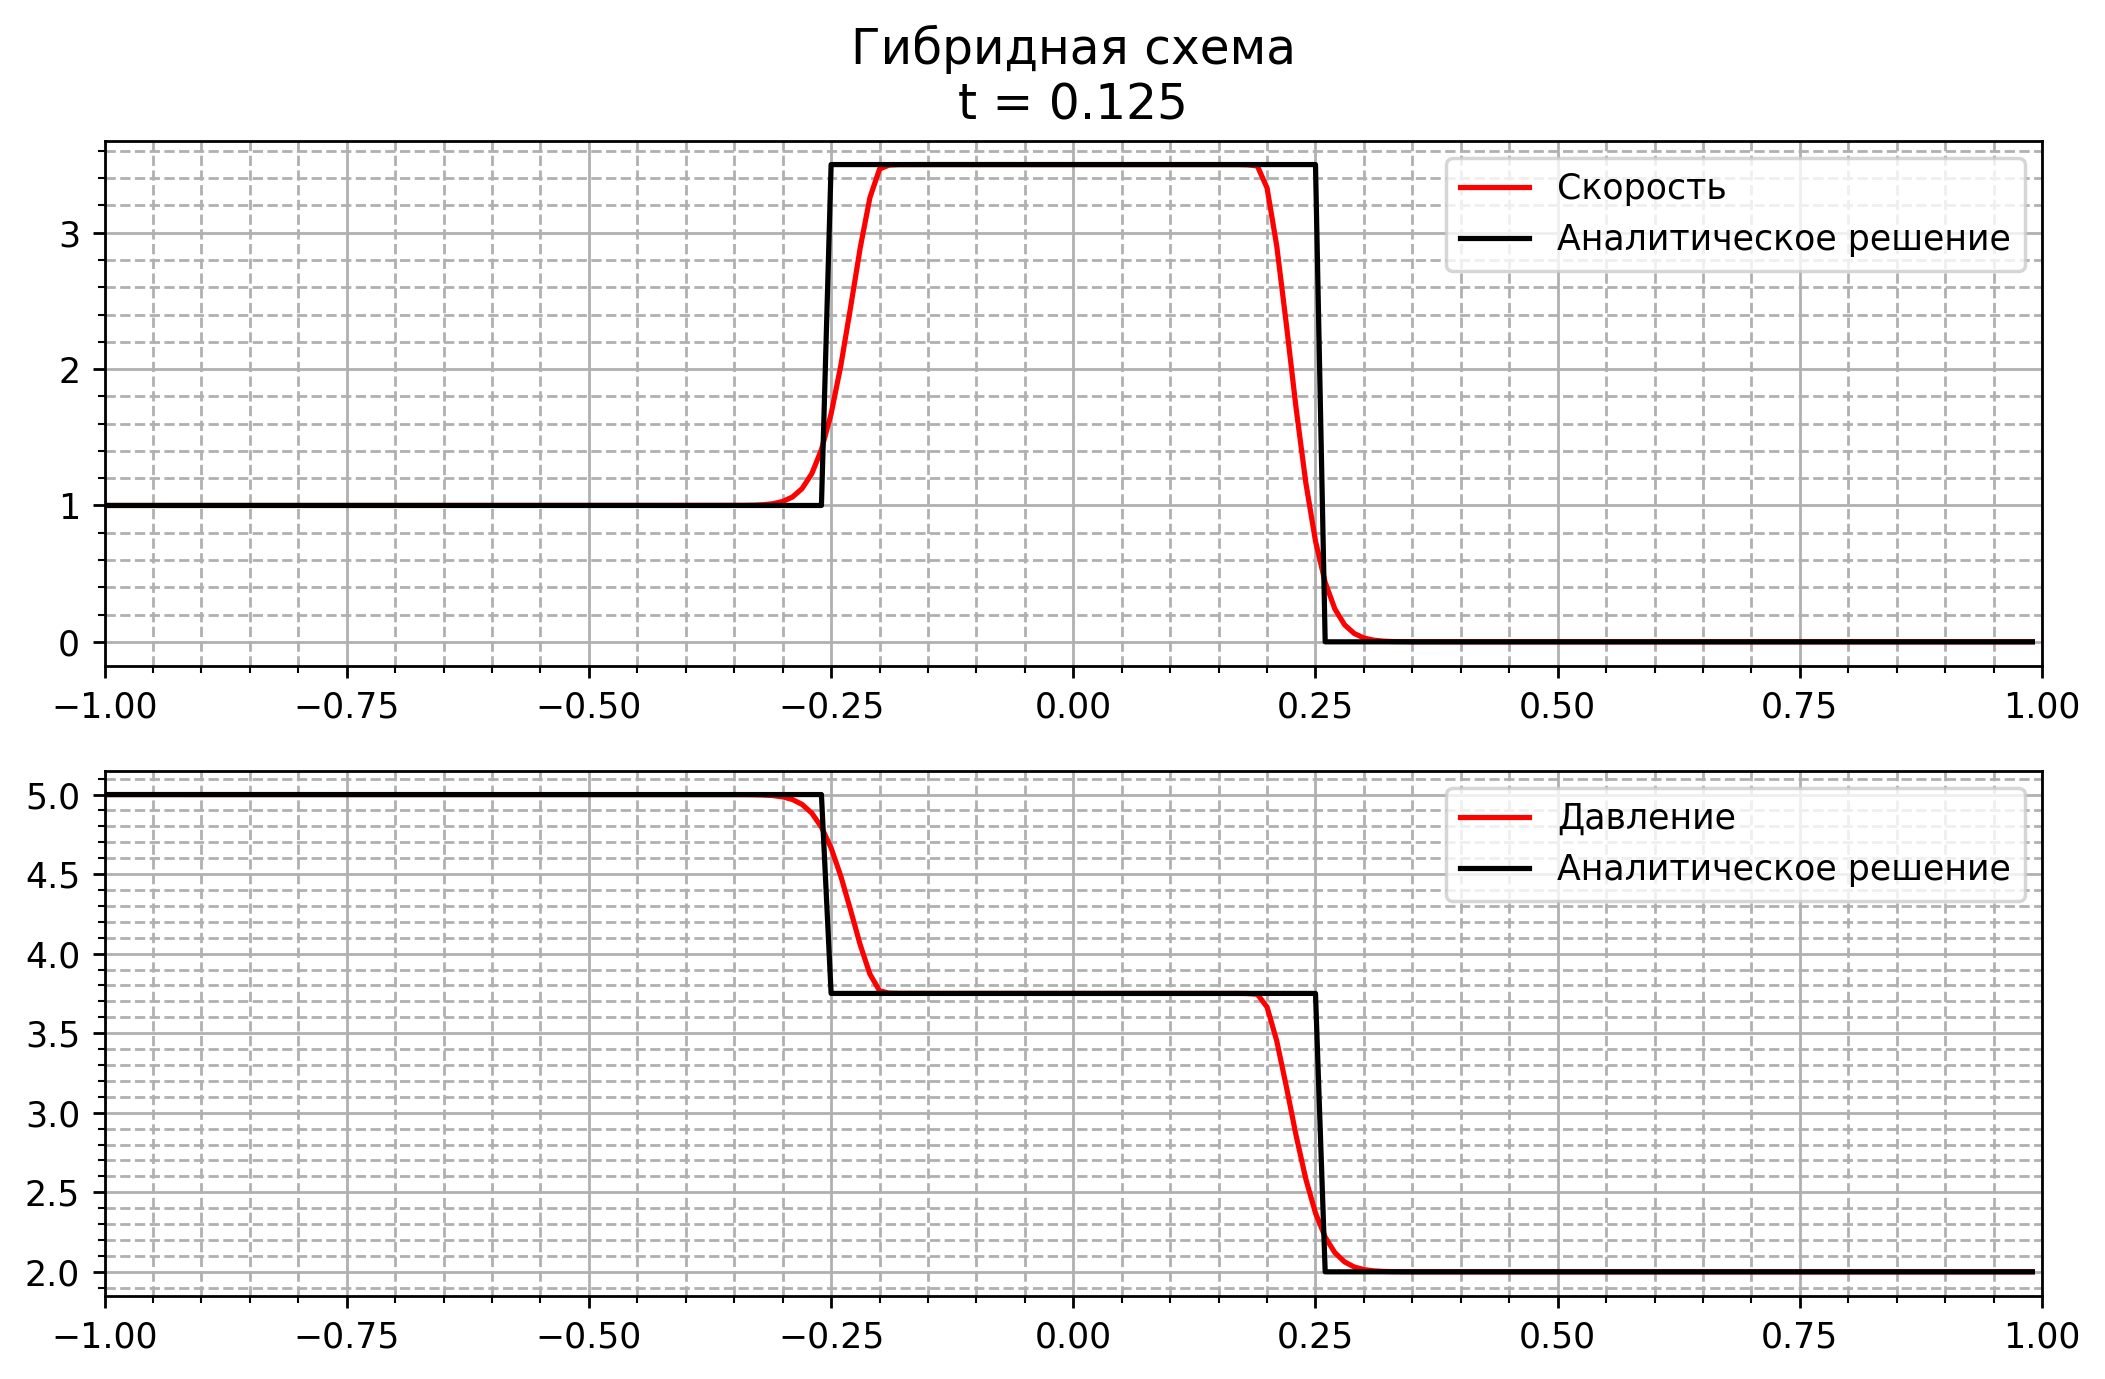

In [ ]:
# Лучшая гибридная схема
plot_title = 'best_hybrid'

a1 = 3. / 5
a2 = -1. / 3
a3 = 3. / 4
a4 = - 1. / 60

coeffs = np.array([a1, a2, a3, a4])

a1 = 0.5
a2 = -0.5
a3 = 1
a4 = 0 

alt_coeffs1 = np.array([a1, a2, a3, a4])

a1 = 27. / 30
a2 = 1. / 6
a3 = 0
a4 = -1. / 15

alt_coeffs2 = np.array([a1, a2, a3, a4])

Y, r, t = solveTransfer( c, Y_init, [a1, a2, a3, a4], alt_coeffs_1= alt_coeffs1, alt_coeffs_2= alt_coeffs2)
Z, r, t = solveTransfer(-c, Z_init, [a1, a2, a3, a4], alt_coeffs_1= alt_coeffs1, alt_coeffs_2= alt_coeffs2)

YZ = np.vstack([Y[-1, :], Z[-1, :]])

UP = omega @ YZ

p_true, u_true = analytic_solution(r, t[-1])

fig, ax = plt.subplots(2, 1, figsize=(10, 6), dpi= 250)
ax[0].plot(r, UP[0, :], label= 'Скорость', c = 'red')
ax[0].plot(r, u_true, label= 'Аналитическое решение', c = 'black')
ax[0].legend(loc = 'best')
ax[0].set_title(f'Гибридная схема\nt = {t[-1]}', fontsize=14)
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle='--')
ax[0].minorticks_on()
ax[0].set_xlim((-1., 1.))

ax[1].plot(r, UP[1, :], label= 'Давление', c = 'red')
ax[1].plot(r, p_true, label= 'Аналитическое решение', c = 'black')
ax[1].legend(loc = 'best')
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle='--')
ax[1].minorticks_on()
ax[1].set_xlim((-1., 1.))

fig.savefig(plot_title + '.png', 
    transparent = False,  
    facecolor = 'white'
)